<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Price Valuation model exploration



Here we explore the price valuation model

## 1. Read Data and feature engineeer

### 1.1 Import libraries

In [1]:
from flask import Flask, request, jsonify
import logging
import pandas as pd

# config file
import configparser

# get logger
from src.logger import AppJsonFormatter

# sql queries and feature selection
from src.driver import *
from src.data import get_data


from src.helper import fillna_mode, remove_outliers, add_bins
from src.plots import hued_pairplot




config_paths = "config/config.ini"

config = configparser.ConfigParser()
config.read(config_paths)


app = Flask(__name__)



app_name = config["APP"]["name"]
app_version = config["APP"]["version"]


# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

log_handler = logging.StreamHandler()

# Set up a custom format for the JsonFormatter
format_str = '%(levelname)s %(asctime)s %(app_name)s %(app_version)s %(message)s'
formatter = AppJsonFormatter(app_name, app_version, fmt=format_str)
log_handler.setFormatter(formatter)
logger.addHandler(log_handler)

logger.info("Flask app started")

{"levelname": "INFO", "asctime": "2023-06-19 09:56:02,721", "app_name": "price", "app_version": "0.0.1", "message": "Flask app started"}


## Data preparation

### first look

10% with a common price of 0

only 5k bikes with the status sold.

this might be too little data,



### work flow

* Feature engineering
    * select categorical and numerical features to encode
* train test split

## to-does:

* join with booking for sales price
* colab cool analyses

In [2]:
df = get_data(main_query=main_query, main_query_dtype=main_query_dtype, index_col="id", popularity_query = popularity_query, config_paths='config/config.ini')

In [3]:
df.shape

(4439, 24)

In [4]:
# count all NAN values per column
df.isna().sum()


recommended_price          10
sales_price                20
msrp                        0
bike_created_at             0
bike_created_at_year        0
bike_created_at_month       0
bike_year                   1
sales_duration              0
sales_country_id         1050
booking_country_id        288
bike_type_id                0
bike_category_id            4
motor                     388
city                        8
frame_size_code             1
price                       1
brake_type_code            66
frame_material_code        82
shifting_code              25
bike_component_id          58
color                      18
family_model_id             0
family_id                 253
brand_id                    1
dtype: int64

In [5]:
df = fillna_mode(df)

In [6]:
df

,recommended_price,sales_price,msrp,bike_created_at,bike_created_at_year,bike_created_at_month,bike_year,sales_duration,sales_country_id,booking_country_id,...,frame_size_code,price,brake_type_code,frame_material_code,shifting_code,bike_component_id,color,family_model_id,family_id,brand_id
id,,,,,,,,,,,,,,,,,,,,,
14127,918.44,2000.0,1399.0,2021-05-24 15:42:54,2021,5,2019.0,583,150.0,150.0,...,56,1100.0,hydraulic,carbon,mechanical,17,#000000,1604,716,30
14127,918.44,2000.0,1399.0,2021-05-24 15:42:54,2021,5,2019.0,583,150.0,150.0,...,56,1100.0,hydraulic,carbon,mechanical,17,#000000,1604,716,30
14147,4444.9,2000.0,5899.0,2021-05-27 14:23:54,2021,5,2020.0,580,150.0,150.0,...,49,1.0,hydraulic,aluminum,mechanical,13,#111827,1918,1892,36
14148,4143.5,2000.0,5499.0,2021-05-27 14:36:25,2021,5,2020.0,722,150.0,150.0,...,49,1.0,hydraulic,carbon,mechanical,13,#111827,1,1730,1
14149,7157.5,2000.0,9499.0,2021-05-27 14:39:59,2021,5,2020.0,580,150.0,150.0,...,49,1.0,hydraulic,carbon,mechanical,13,#111827,154,1108,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247093,4423.952,3700.0,7049.0,2023-05-30 10:11:07,2023,5,2022.0,17,152.0,150.0,...,l,4100.0,hydraulic,carbon,mechanical,35,#FFFFFF,13776,79,123
283431,707.4,500.0,3000.0,2023-06-07 14:01:44,2023,6,1990.0,9,150.0,150.0,...,59,500.0,rim,aluminum,mechanical,17,#9A2DF0,8428,514,131
214046,1599.64,1300.0,2900.0,2023-05-01 15:53:20,2023,5,2020.0,45,150.0,148.0,...,l,1600.0,hydraulic,aluminum,mechanical,36,#4B5563,14802,252,45


In [58]:
df["price_diff"] = abs(df["recommended_price"] - df["sales_price"])
df["price_diff"].describe()

/tmp/ipykernel_15994/1638891737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price_diff"] = abs(df["recommended_price"] - df["sales_price"])


count         4245.0
mean       776.43013
std      1037.561421
min              0.0
25%        122.06025
50%            329.7
75%            972.2
max         9593.575
Name: price_diff, dtype: Float64

In [8]:

# statistical summary for price_diff group by bike_type
df.groupby('bike_type_id')['price_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
bike_type_id,,,,,,,,
1,3624.0,296.570079,1317.382838,-5999.0,-204.91375,67.755,499.0,9593.575
2,815.0,469.592641,1461.262804,-4150.0,-80.0625,215.975,825.095,5045.0


In [9]:
df.columns

Index(['recommended_price', 'sales_price', 'msrp', 'bike_created_at',
       'bike_created_at_year', 'bike_created_at_month', 'bike_year',
       'sales_duration', 'sales_country_id', 'booking_country_id',
       'bike_type_id', 'bike_category_id', 'motor', 'city', 'frame_size_code',
       'price', 'brake_type_code', 'frame_material_code', 'shifting_code',
       'bike_component_id', 'color', 'family_model_id', 'family_id',
       'brand_id', 'price_diff'],
      dtype='object')

In [10]:

cols_analysis = ['bike_type_id',
                 'bike_created_at_year',
                 'msrp',
                 'bike_created_at_month',
                 'sales_duration',
                 'sales_country_id',
                 'booking_country_id',
                 'sales_price',
                 'price_diff']

Y_column = ['sales_price']

X_categaorical_column = ['bike_type_id',
                     'bike_created_at_year',
                     'bike_category_id',
                     'bike_component_id',
                   #  'frame_material_code',
                     'sales_country_id',
                     'motor',
                     'color',
                     'brand_id',
                     'family_id',
                     'family_model_id',
                     'bike_type_id',
                     'bike_created_at_month',
                     'bike_year',
                     'city']

X_numerical_column = ['msrp', ]






In [11]:
df = remove_outliers(df, ['sales_price'], quantile=0.02)

In [12]:

import numpy as np


from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from xgboost import XGBRegressor

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

# Transform: oneHotEncoder for categorical
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


# Preprocessor - Scale and Encode
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_numerical_column),
        ("cat", categorical_transformer, X_categaorical_column),
    ]
)


In [13]:
# transfer this into a sklearn pipeline

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(Y_column, axis = 1, inplace = False), df[Y_column], test_size=0.05, random_state=0)

In [15]:
X_train.shape

(4032, 24)

In [16]:
model = Pipeline(steps=[('pre', preprocessor),
                        ('XGB', XGBRegressor(
                                       eval_metric = 'rmse',
                                       objective = 'reg:squarederror',
                                       cv =5))])

In [17]:
clf =model.fit(X_train, y_train)

[09:56:03] WARNING: ../src/learner.cc:767: 
Parameters: { "cv" } are not used.



In [18]:
y_pred = np.ndarray.astype(np.around(clf.predict(X_test), decimals=0), int)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mpe = mean_absolute_percentage_error(y_test, y_pred)

print("MPE: %.5f" % mpe)
print("MAE: %.5f" % mae)
print("MSE: %.5f" % mse)
print("RMSE: %.5f" % (mse**(1/2.0)))
# print



MPE: 0.18985
MAE: 324.01878
MSE: 192851.80282
RMSE: 439.14895


In [57]:
# get statistics for the difference between y_test and y_pred
abs((pd.DataFrame(y_pred) - pd.DataFrame(y_test).values)[0]).astype(int).describe()




count     213.000000
mean      324.018779
std       297.116281
min         1.000000
25%        95.000000
50%       235.000000
75%       484.000000
max      1856.000000
Name: 0, dtype: float64

In [ ]:
#compare prediciton with actual
y_test["pred"] = y_pred
y_test["diff"] = y_test["sales_price"] - y_test["pred"]

In [63]:
# show the first two rows odered bu desc oder by diff
y_test.sort_values(by=['diff'], ascending=False).head(100)

,sales_price,pred,diff
id,,,
194326,5500.0,2907,2593.0
88494,3800.0,1863,1937.0
217652,5750.0,3821,1929.0
81179,5500.0,3644,1856.0
127580,5500.0,3829,1671.0
...,...,...,...
80619,1700.0,1410,290.0
86502,2900.0,2614,286.0
118635,3600.0,3320,280.0


<Axes: >

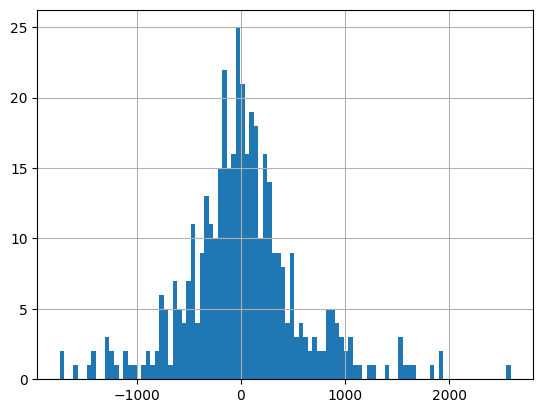

In [64]:
y_test['diff'].hist(bins=100)

In [26]:
pd.DataFrame(y_pred)

,0
0,3252
1,613
2,1276
3,1929
4,2131
...,...
411,1954
412,1285
413,3819
414,2349


In [ ]:
sdf

In [ ]:

df = add_bins(df, ['price_diff'], bins=[-2000,-100, -50, 0, 50, 100, 2000])

df = add_bins(df, ['sales_duration'], bins=[0, 14, 28, 50, 100, 250,10000])

In [ ]:
df.price_diff_bin


id
18920       (100, 2000]
18783     (-2000, -100]
19942     (-2000, -100]
19203          (-50, 0]
20227         (50, 100]
              ...      
220918        (50, 100]
224191      (100, 2000]
197824      (100, 2000]
224699      (100, 2000]
220365      (100, 2000]
Name: price_diff_bin, Length: 3729, dtype: category
Categories (6, interval[int64, right]): [(-2000, -100] < (-100, -50] < (-50, 0] < (0, 50] < (50, 100] < (100, 2000]]

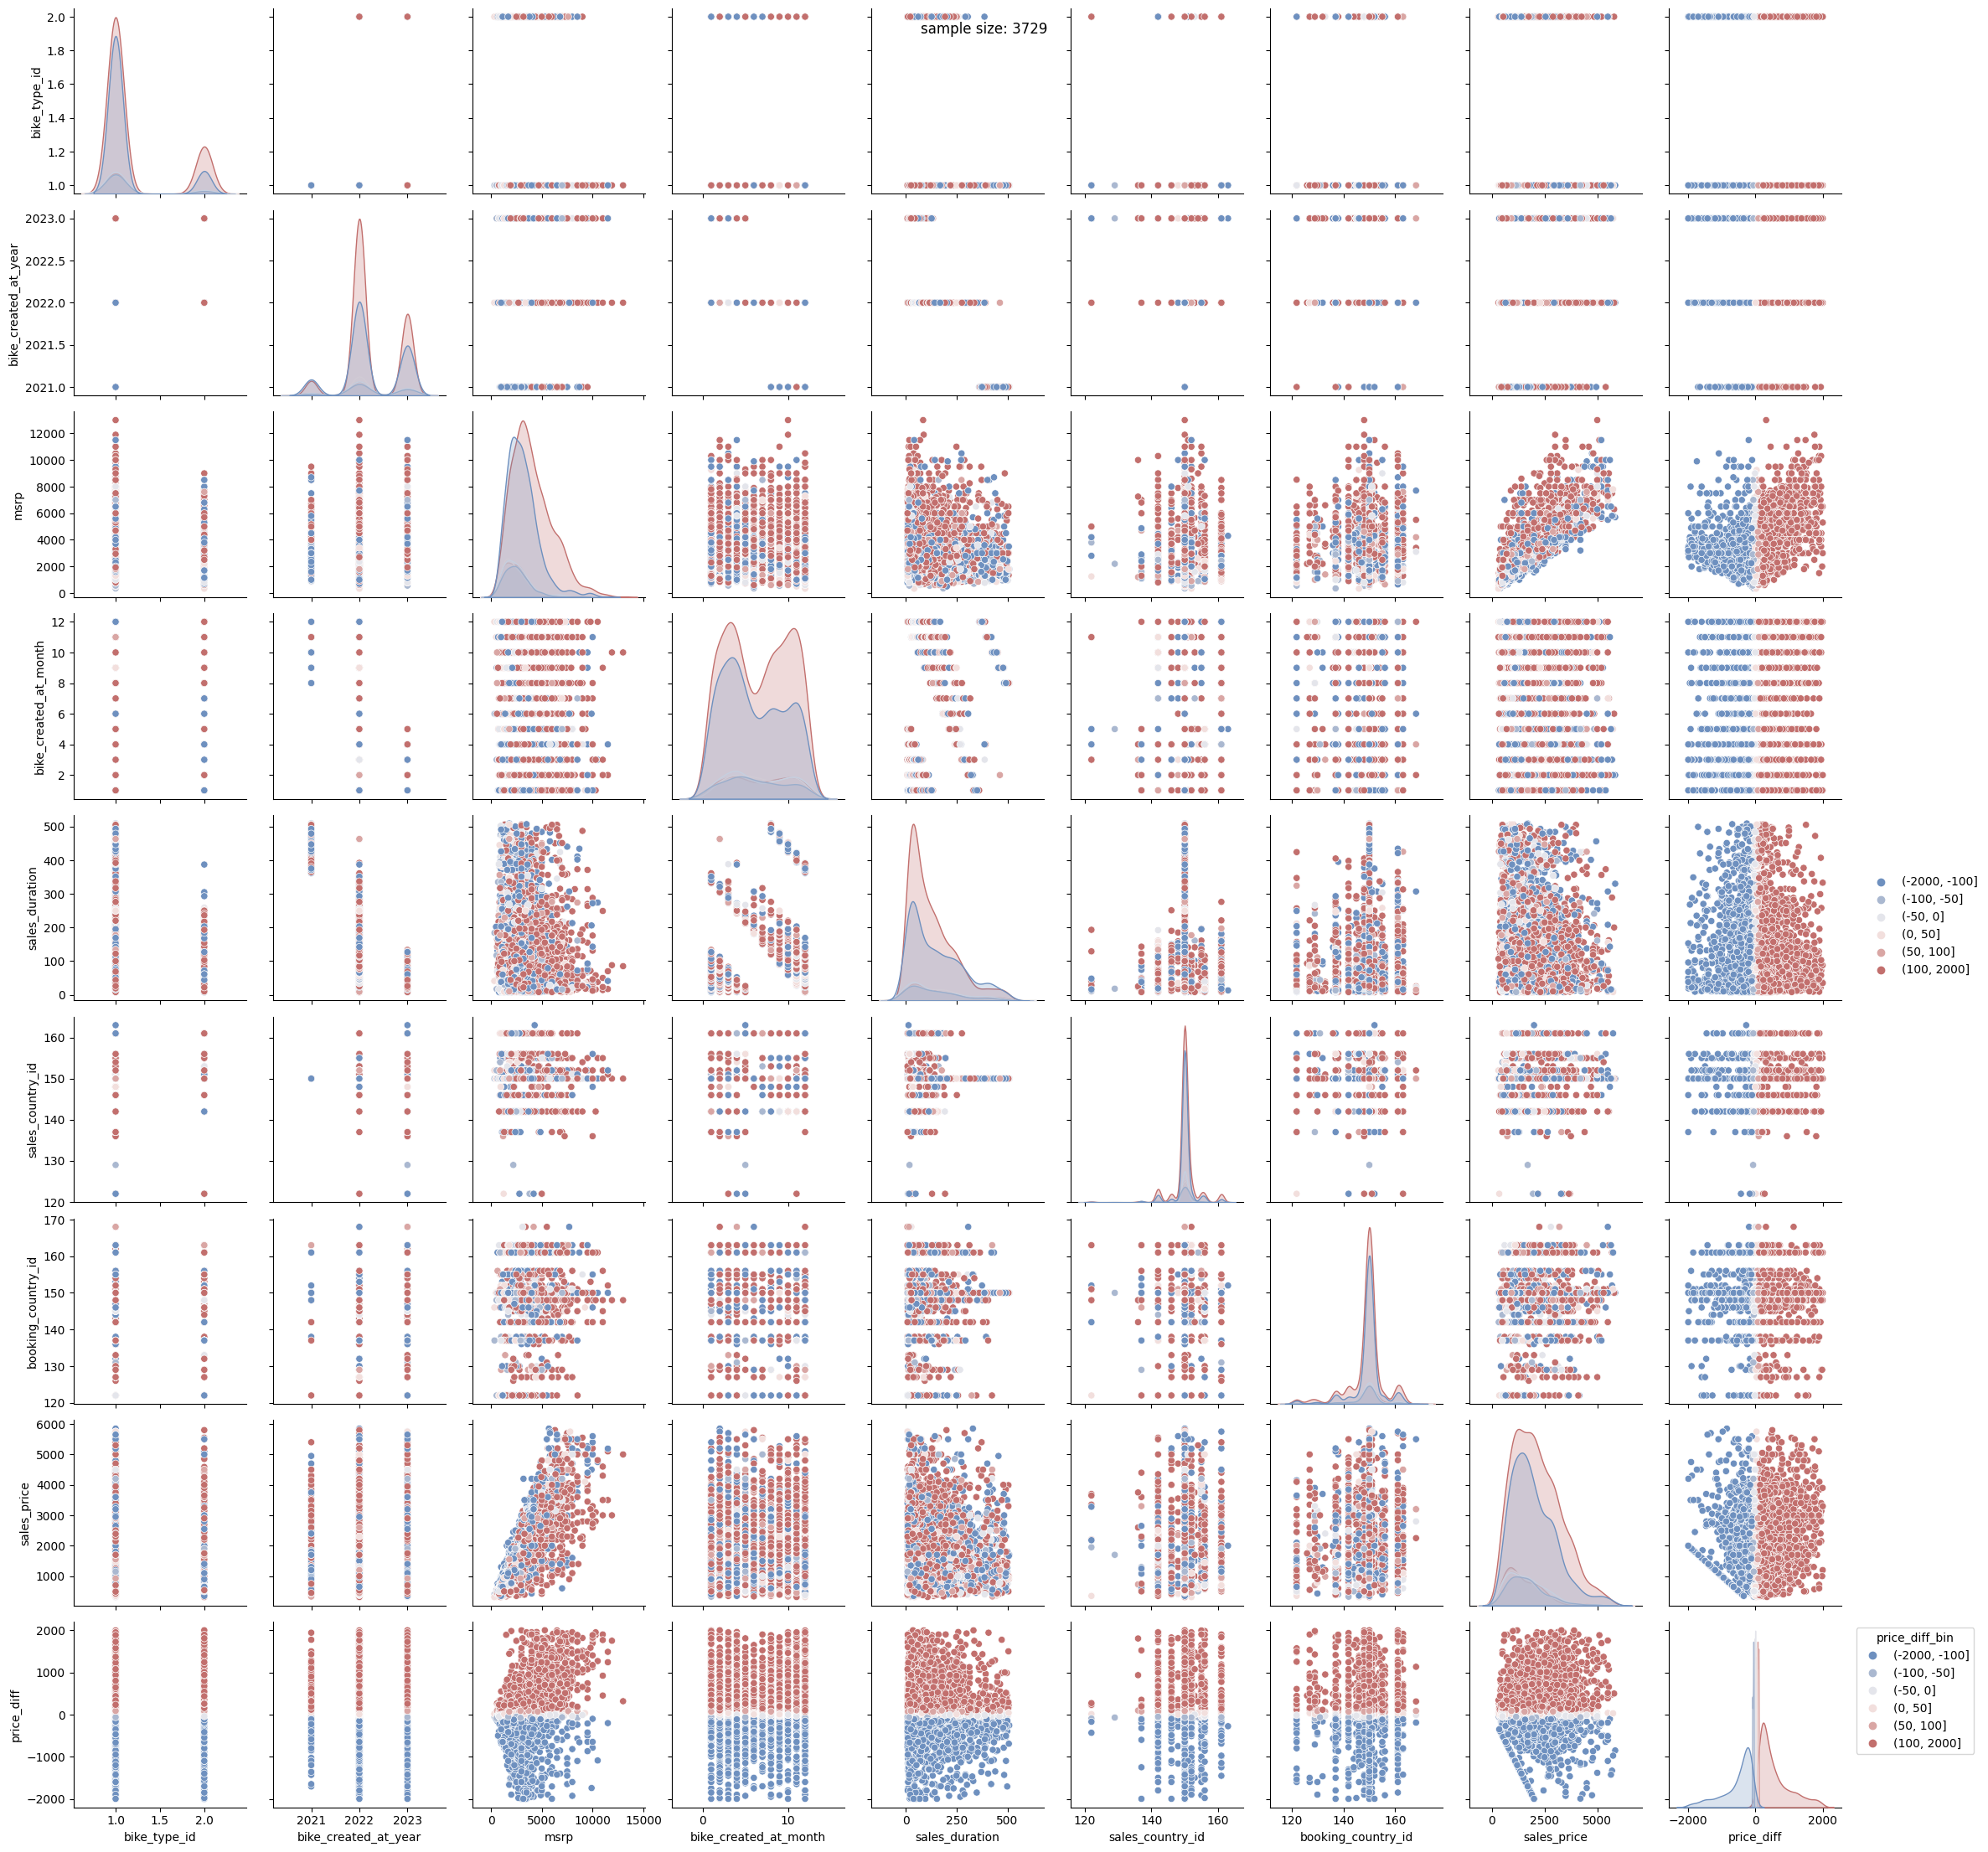

In [ ]:
   
hued_pairplot(df, cols_analysis, 'price_diff_bin')
#hued_pairplot(df, cols_analysis, 'sales_duration_bin')

In [ ]:
df[df['bike_created_at_year'] == 2022]

,recommended_price,sales_price,msrp,bike_created_at,bike_created_at_year,bike_created_at_month,sales_duration,sales_country_id,booking_country_id,bike_type_id,...,frame_material_code,shifting_code,bike_component_id,color,family_model_id,family_id,brand_id,price_diff,price_diff_bin,sales_duration_bin
id,,,,,,,,,,,,,,,,,,,,,
30367,6175.43,4500.0,7499.0,2022-01-03 13:39:29,2022,1,359,150.0,150.0,1.0,...,carbon,electronic,14,#000000,881,824,20,1675.43,"(100.0, 2000.0]","(250, 10000]"
30633,5240.68,3900.0,7299.0,2022-01-05 22:08:49,2022,1,357,150.0,150.0,1.0,...,carbon,electronic,23,#FFFFFF,577,805,14,1340.68,"(100.0, 2000.0]","(250, 10000]"
30281,2100.14,2100.0,3199.0,2022-01-02 14:35:34,2022,1,360,150.0,150.0,1.0,...,carbon,mechanical,27,#808080,7158,1083,123,0.14,"(0.0, 50.0]","(250, 10000]"
32084,1115.39,1.0,1699.0,2022-01-21 15:06:52,2022,1,341,150.0,150.0,1.0,...,aluminum,mechanical,13,#000000,1085,1108,21,1114.39,"(100.0, 2000.0]","(250, 10000]"
32084,1115.39,1.0,1699.0,2022-01-21 15:06:52,2022,1,341,150.0,150.0,1.0,...,aluminum,mechanical,13,#000000,1085,1108,21,1114.39,"(100.0, 2000.0]","(250, 10000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106085,1318.46,1000.0,2699.0,2022-10-18 21:21:17,2022,10,220,150.0,150.0,1.0,...,carbon,electronic,14,#EF4444,9147,2644,173,318.46,"(100.0, 2000.0]","(100, 250]"
106333,4940.18,3999.0,5999.0,2022-10-19 19:54:02,2022,10,217,150.0,150.0,2.0,...,carbon,mechanical,57,#F9FAFB,15518,3121,184,941.18,"(100.0, 2000.0]","(100, 250]"
96024,4751.135,1600.0,2300.0,2022-09-07 21:54:17,2022,9,260,150.0,150.0,2.0,...,aluminum,mechanical,52,#111827,27077,2664,527,3151.135,NaN,"(250, 10000]"


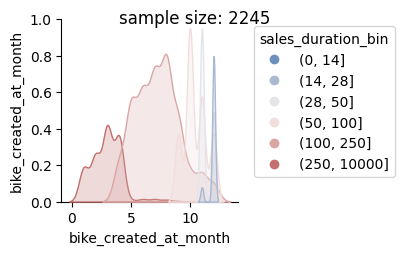

In [ ]:
df = add_bins(df, ['sales_duration'], bins=[0, 14, 28, 50, 100, 250,10000])

# df year == 2022
hued_pairplot(df[df['bike_created_at_year'] == 2022], ['bike_created_at_month'], 'sales_duration_bin')


In [ ]:
df

,recommended_price,sales_price,msrp,bike_created_at,bike_created_at_year,bike_created_at_month,sales_duration,sales_country_id,booking_country_id,bike_type_id,...,frame_material_code,shifting_code,bike_component_id,color,family_model_id,family_id,brand_id,price_diff,price_diff_bin,sales_duration_bin
id,,,,,,,,,,,,,,,,,,,,,
18920,1069.73,900.0,1349.0,2021-08-09 16:51:53,2021.0,8.0,506.0,150.0,150.0,1.0,...,aluminum,mechanical,18,#000000,6268,1048,110,169.7300,"(100, 2000]","(250, 10000]"
18783,1443.6,1700.0,1799.0,2021-08-06 22:43:07,2021.0,8.0,509.0,150.0,150.0,1.0,...,aluminum,mechanical,17,#000000,7235,597,123,-256.4000,"(-2000, -100]","(250, 10000]"
19942,753.25,1150.0,1499.0,2021-08-16 18:35:32,2021.0,8.0,499.0,150.0,150.0,1.0,...,aluminum,mechanical,17,#000000,1085,1108,21,-396.7500,"(-2000, -100]","(250, 10000]"
19203,721.385,750.0,949.0,2021-08-13 19:24:52,2021.0,8.0,502.0,150.0,150.0,1.0,...,aluminum,mechanical,19,#800080,1618,715,30,-28.6150,"(-50, 0]","(250, 10000]"
20227,1794.28,1699.0,2499.0,2021-08-18 13:13:31,2021.0,8.0,497.0,150.0,150.0,1.0,...,carbon,mechanical,15,#000000,1647,74,30,95.2800,"(50, 100]","(250, 10000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220918,1012.3335,925.0,2899.0,2023-05-06 14:03:54,2023.0,5.0,25.0,150.0,150.0,1.0,...,carbon,mechanical,13,#80BE70,10188,1737,11,87.3335,"(50, 100]","(14, 28]"
224191,1034.1225,700.0,2950.0,2023-05-09 08:03:19,2023.0,5.0,19.0,152.0,152.0,1.0,...,carbon,mechanical,13,#4B5563,6926,132,113,334.1225,"(100, 2000]","(14, 28]"
197824,722.41,490.0,1929.0,2023-04-12 20:41:05,2023.0,4.0,44.0,142.0,142.0,1.0,...,aluminum,mechanical,17,#FFFFFF,7195,3786,123,232.4100,"(100, 2000]","(28, 50]"


In [ ]:
# format date day month year, remove time
df['bike_created_at'] = pd.to_datetime(df['bike_created_at']).dt.strftime('%d-%m-%Y')

<Axes: xlabel='bike_created_at'>

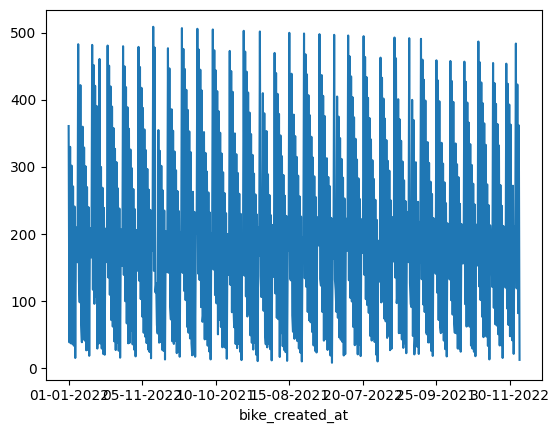

In [ ]:
# line plot of sales duration and sales price
df.groupby('bike_created_at')['sales_duration'].mean().plot()

bike_type_id
1.0    Axes(0.125,0.11;0.775x0.77)
2.0    Axes(0.125,0.11;0.775x0.77)
Name: price_diff, dtype: object

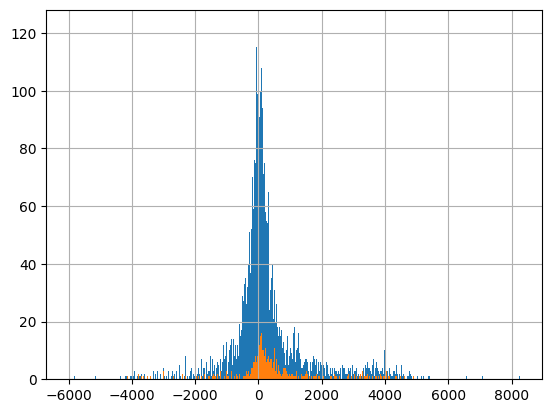

In [ ]:
# show price_diff distribution group by bike_type
df.groupby('bike_type_id')['price_diff'].hist(bins=500)



In [ ]:
# For both bike_type_ids the distribution is skewed to the right, with a long tail of high values.
# This is more true for the bike_type_id 2 (MTB)

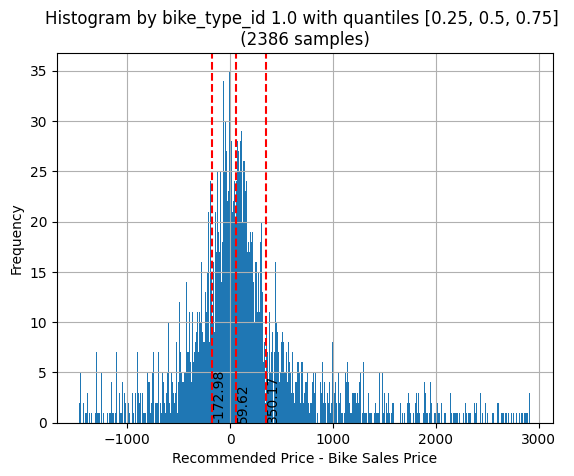

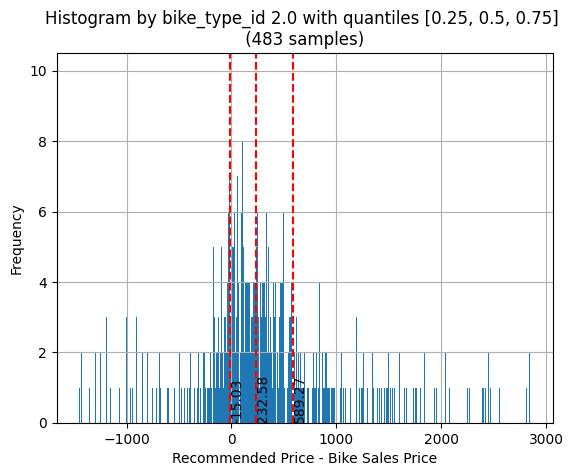

In [ ]:
quantiles = [0.25, 0.5, 0.75]
col = "price_diff"
by = "bike_type_id"
x_label = "Recommended Price - Bike Sales Price"

plot_quantiles(df, x_label, col, by, quantiles)


,bike_type_id,msrp,bike_created_at_month,sales_duration,sales_country_id,booking_country_id,sales_price,price_diff
bike_type_id,1.000000,0.019337,-0.025544,-0.162567,0.019583,-0.058882,-0.012085,0.050395
msrp,0.019337,1.000000,-0.023242,-0.058139,0.024015,0.010547,0.764950,0.135274
bike_created_at_month,-0.025544,-0.023242,1.000000,0.137871,-0.002627,0.046119,0.034525,0.012209
sales_duration,-0.162567,-0.058139,0.137871,1.000000,0.005033,0.100035,-0.030465,-0.139257
sales_country_id,0.019583,0.024015,-0.002627,0.005033,1.000000,0.006282,0.047825,-0.007233
booking_country_id,-0.058882,0.010547,0.046119,0.100035,0.006282,1.000000,0.021690,-0.020583
sales_price,-0.012085,0.764950,0.034525,-0.030465,0.047825,0.021690,1.000000,-0.069083
price_diff,0.050395,0.135274,0.012209,-0.139257,-0.007233,-0.020583,-0.069083,1.000000


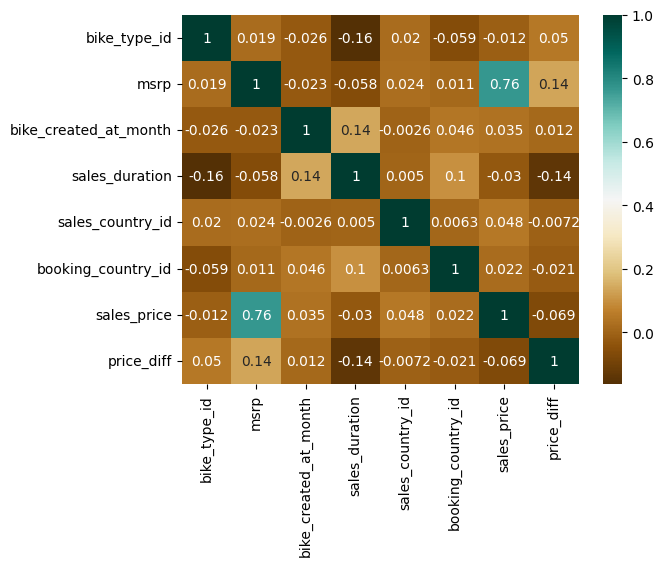

#### known issues:
#### further development:

In [ ]:

def feature_engineering(df: pd.DataFrame = df, categorical_features: list = categorical_features, numerical_features: list = numerical_features, keepall: bool = True) -> pd.DataFrame:
    """feature engineering for the bike dataframe
        Args:
            df (pandas.DataFrame): dataframe of bikes to feature engineer
            categorical_features (list): list of categorical features
            numerical_features (list): list of numerical features
            keepall (bool): keep all features or just the categorical and numerical features
            
        Returns:
            df (pandas.DataFrame): dataframe of bikes to feature engineer
        
    """
    
    # only keep the categorical and numerical features    
    if not keepall:
        df = df[categorical_features + numerical_features]
       
    # one hot encode the features
    df = pd.get_dummies(df, columns=categorical_features, )

        
    # scale the features
    df[numerical_features] = MinMaxScaler().fit_transform(df[numerical_features])
    
    
    return df
       

In [ ]:
def get_similarity_matrix(df: pd.DataFrame, metric: str = 'cosine') -> pd.DataFrame:  
    """get the cosine similarity matrix for the dataframe
        Args:
            df (pandas.DataFrame): dataframe of bikes to get cosine similarity matrix for
            
        Returns:
            similarity_matrix (numpy.ndarray): cosine similarity matrix for the dataframe
        
            
    """
    # get the cosine similarity matrix
    similarity_matrix = pd.DataFrame(squareform(pdist(df, metric)),
                columns=df.index,
                index=df.index)
    
    
    return similarity_matrix


In [ ]:
def get_top_n_popularity(df_popularity: pd.DataFrame, n: int = 16) -> list:
    """
    Returns the top n recommendation based on popularity
    Args:
        df (pd.Dataframe): df with sorted bike ids by popularity
        n (int): number of recommendations to return
        
    Returns:
        list: list of top n bike ids by populatity
    """
    return df_popularity.head(n).index.tolist()

In [ ]:
def get_top_n_recommendations(similarity_matrix: pd.DataFrame, bike_id: int, n: int = 16) -> list:
    """
    Returns the top n recommendations for a bike_id
    Args:
        similarity_matrix (pd.DataFrame): cosine similarity matrix
        bike_id (int): bike_id to get recommendations for
        n (int): number of recommendations to return
        
    Returns:
        list: list of top n recommendations for bike_id, skipping the bike_id itself
        

    """    
    
    # do not return first element as it is the bike_id itself
    return similarity_matrix[bike_id].nsmallest(n+1).index.tolist()[1:]
 
    




In [ ]:
def get_top_n_recommendations_prefiltered(similarity_matrix: pd.DataFrame, df: pd.DataFrame, bike_id: int, prefilter_features: list, n: int = 4) -> list:
    """
    Returns the top n recommendations for a bike_id with a prefilter applied for the prefilter_features of the specific bike_id
    Args:
        similarity_matrix (pd.DataFrame): cosine similarity matrix
        df (pd.DataFrame): dataframe of bikes
        bike_id (int): bike_id to get recommendations for
        n (int): number of recommendations to return
        
    Returns:
        list: list of top n recommendations for bike_id, skipping the bike_id itself
        

    """    
        
    # get the values of the prefilter_features for the bike_id
    prefilter_values = df.loc[bike_id][prefilter_features]
    
    # filter the similarity_matrix to only include the rows where the values of the prefilter_features are the same as the values of df.loc[bike_id][prefilter_features]
    similarity_matrix = similarity_matrix.loc[(df[prefilter_features] == prefilter_values).all(axis=1)]    
    
    
    
    
 
    
    return similarity_matrix[bike_id].nsmallest(n+1).index.tolist()[1:]
    

In [ ]:
def get_top_n_recommendations_mix(bike_id: int,  ratio: float = 0.5, n: int = 16, df: pd.DataFrame = df, df_popularity: pd.DataFrame = df_popularity, similarity_matrix: pd.DataFrame = similarity_matrix, prefilter_features: list = prefilter_features) -> list:
    """
    this implements the mix of popularity and content based recommendations
    including also a ratio between content based prefiltered and not prefiltered
    this reflects the model specific vs generic recommendations
    
    Logic:
        1. get the top n recommendations based on popularity, return if bike_id not in the df
        2. get the top n recommendations prefiltered by the prefilter_features for n * ratio
        3. get the top n recommendations for the bike_id for n
        4. append the lists of in the order of 2, 3 and 1; ensuring that enough recommendations are returned
    
    Args:
        df (pd.DataFrame): dataframe of bikes
        df_popularity (pd.DataFrame): dataframe of bikes sorted by popularity
        similarity_matrix (pd.DataFrame): cosine similarity matrix
        bike_id (int): bike_id to get recommendations for
        n (int): number of recommendations to return
        
    Returns:
        list: list of top n recommendations for bike_id
        
    to-does:
        do not return the bike_id of the recommended for bike
    """    
    
    top_n_popularity = get_top_n_popularity(df_popularity, n)
        
    if bike_id not in df.index:
        return top_n_popularity
        
    else:
        # prefiltered
        top_n_recommendations_prefiltered = get_top_n_recommendations_prefiltered(similarity_matrix, df, bike_id, prefilter_features, int(n*ratio))
        
        # get the top n recommendations for the bike_id
        top_n_recommendations_generic = get_top_n_recommendations(similarity_matrix, bike_id, int(n))
        
        # combine the two lists
        top_n_recommendations = top_n_recommendations_prefiltered + top_n_recommendations_generic + top_n_popularity
        
        # remove duplicates
        top_n_recommendations = list(dict.fromkeys(top_n_recommendations))
        
        # return the top n recommendations
        return top_n_recommendations[:n]
        
        


### Driver


In [ ]:
main_query = """SELECT id,
                       
                       
                       -- categorizing
                       bike_type_id,
                       bike_category_id,
                       motor,
                       
                       -- cetegorizing fuzzy
                       
                       frame_size_code, 
                       
                       
                       -- very important
                       price,
                       brake_type_code,
                       frame_material_code,
                       shifting_code,
                       
                       
                       -- important
                       
                       year,
                       msrp,                       
                       
                       bike_component_id,
                       
                       -- find similarity between hex codes                      
                       color,
                       
                       -- quite specific
                       family_model_id,
                       family_id,
                       brand_id
                       
                       
                       
                       
                FROM bikes
                
                -- not sure if this is correct
                -- we might also need recommendations for bikes that are not active, ask Masso
                WHERE status = 'active'
                
                -- LIMIT 1000
                
             """

In [ ]:
popularity_query = """SELECT id
                       
                FROM bikes
                
                -- not sure if this is correct
                -- we might also need recommendations for bikes that are not active
                WHERE status = 'active'
                
                
                ORDER BY count_of_visits DESC
                
             """

In [ ]:
# the family model id and family_id make the feature engineered matrix high dimensional
# only needed for model specific recommendations
# here we can filter the sql_df to only include the family model id and family_id,
# for the content based recommendation we can remove the family_model_id and 'family_id'

# features for which to prefilter for the specific recommendations
prefilter_features = ['family_model_id', 'family_id']


categorical_features = [ 'brand_id', 'motor', 'bike_component_id','bike_category_id', 'bike_type_id', 'frame_size_code', 'brake_type_code', 'frame_material_code', 'shifting_code', 'color']
numerical_features = ['price', 'year', 'msrp']


In [ ]:

# the family model id and family_id lead to a high dimensionality of the feature engineered data after one-hot encoding
# only needed for model specific recommendations
# here we can filter the sql_df to only include the family model id and family_id,


# features for which to prefilter for the specific recommendations
# family_id should be complete
prefilter_features = ['family_model_id', 'family_id']

# for the content based recommendation we disregard prefilter_features and use generic features that represent the qualities of the bike
categorical_features = [ 'brand_id', 'motor', 'bike_component_id','bike_category_id', 'bike_type_id', 'frame_size_code', 'brake_type_code', 'frame_material_code', 'shifting_code', 'color']
numerical_features = ['price', 'year', 'msrp']


In [ ]:
def get_data(main_query: str = main_query, popularity_query: str = popularity_query, config_paths: str = 'config/config.ini') -> pd.DataFrame:
    """
    Args:
        config_paths: path to config file
        main_query: query to get main data
        popularity_query: query to get popularity data
        
    Returns:
        df: main data
        df_popularity: popularity data
    """
    
    config = configparser.ConfigParser()
    config.read(config_paths)
    
    

    user = config['DATABASE']['user']
    host = config['DATABASE']['host']
    port = int(config['DATABASE']['port'])
    dbname = config['DATABASE']['dbname']
    password = config['DATABASE']['password']
    
    # Create the connection
    engine = create_engine(
        url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(
            user, password, host, port, dbname
        )
    )
 
    
    df = pd.read_sql( 
    sql=main_query,
    con=engine,
    index_col='id')
    
    df_popularity = pd.read_sql( 
    sql=popularity_query,
    con=engine,
    index_col='id')
    
    return df, df_popularity

In [ ]:
%%time


def create_data(path: str = 'data/'):
    """
    Create data and save it to disk
    Args:
        path: path to save data
        
    """

    df, df_popularity = get_data()
    df = feature_engineering()
    
    similarity_matrix = get_similarity_matrix(df=df, metric='cosine')
    
    # write df, df_popularity, similarity_matrix to disk
    df.to_csv(path + 'df.csv')
    df_popularity.to_csv(path + 'df_popularity.csv')
    np.save(path + 'similarity_matrix.npy', similarity_matrix)




CPU times: user 1min 8s, sys: 1.02 s, total: 1min 9s
Wall time: 1min 9s


In [ ]:
def read_data(path: str = 'data/'):
    """
    Read data from disk
    Args:
        path: path to save data
        
    Returns:
        df: main data
        df_popularity: popularity data
        similarity_matrix: similarity matrix
    """
    
    df = pd.read_csv(path + 'df.csv', index_col='id')
    df_popularity = pd.read_csv(path + 'df_popularity.csv', index_col='id')
    similarity_matrix = np.load(path + 'similarity_matrix.npy')
    
    return df, df_popularity, similarity_matrix



In [ ]:
def main(bike_id: int, ratio: float = 0.5, n: int = 16) -> list:
    """
    Driver function for the recommender system
    Args:
        bike_id (int): bike_id to get recommendations for
        ratio (float): ratio of prefiltered recommendations vs generic recommendations
        n (int): number of recommendations to return
    Returns:
        list: list of top n recommendations for bike_id
    """
    
    # read data from disc if it does not exist
    if df.empty or df_popularity.empty or similarity_matrix.empty:

        df, df_popularity, similarity_matrix = read_data()
    
    
    
    return get_top_n_recommendations_mix(bike_id, ratio, n)

### Testing

In [ ]:
# design different weights matrices for specific and exploratory recommendations, check the results

def weights_array(df: pd.DataFrame) -> np.array:

    """Args:
        df (pd.DataFrame): dataframe of feature engineered bikes
        
    Returns:
        weights (np.array): array of weights
    """
    
    
    weights = np.random.uniform(low = 0, high = 1, size= (len(df.columns),))
    
    # check how many categorical features and iteratively build weights array
    # go through columns names and construct weights array from dict input


    return weights

In [ ]:

# looks like euclidean distance is more genral and cosine is more specific

In [ ]:
%%time
df = feature_engineering(df, categorical_features, numerical_features, keepall=False)

CPU times: user 92.6 ms, sys: 4.04 ms, total: 96.6 ms
Wall time: 95.6 ms


In [ ]:
%%time
get_similarity_matrix(df, 'cosine')

CPU times: user 1min 6s, sys: 1.03 s, total: 1min 7s
Wall time: 1min 7s


id,14394,14602,14627,15025,15297,15450,15455,15502,15580,15593,...,201988,201991,202008,202025,202033,202061,202062,202064,202070,202084
id,,,,,,,,,,,,,,,,,,,,,
14394,0.000000,0.503201,0.403216,0.552071,0.499689,0.547800,0.549556,0.641951,0.464839,0.553121,...,0.638080,0.821804,0.735598,0.819153,0.821018,0.819365,0.547841,0.822883,0.730996,0.639269
14602,0.503201,0.000000,0.342018,0.405390,0.225824,0.299663,0.403098,0.505875,0.409818,0.405840,...,0.604483,0.808799,0.712327,0.805729,0.808167,0.805259,0.401494,0.809909,0.707832,0.605334
14627,0.403216,0.342018,0.000000,0.303696,0.340223,0.403284,0.404710,0.507922,0.306980,0.510398,...,0.607164,0.812506,0.715200,0.809714,0.811841,0.809517,0.505582,0.813557,0.710902,0.608047
15025,0.552071,0.405390,0.303696,0.000000,0.402920,0.460670,0.461621,0.462144,0.280564,0.464285,...,0.643395,0.736633,0.741046,0.734841,0.735895,0.827145,0.460642,0.737479,0.644781,0.644643
15297,0.499689,0.225824,0.340223,0.402920,0.000000,0.197389,0.400713,0.502834,0.408150,0.404166,...,0.599889,0.803391,0.707858,0.800695,0.802426,0.801345,0.399321,0.804570,0.702716,0.601387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202061,0.819365,0.805259,0.809517,0.827145,0.801345,0.636698,0.640334,0.823452,0.742491,0.735495,...,0.637846,0.274254,0.551632,0.452950,0.455985,0.000000,0.727787,0.456553,0.548366,0.728541
202062,0.547841,0.401494,0.505582,0.460642,0.399321,0.365200,0.458309,0.458897,0.279872,0.276930,...,0.547473,0.822069,0.644091,0.819039,0.821434,0.727787,0.000000,0.823160,0.731547,0.548145
202064,0.822883,0.809909,0.813557,0.737479,0.804570,0.731587,0.734125,0.918726,0.836892,0.830734,...,0.730886,0.274449,0.644850,0.364869,0.365677,0.456553,0.823160,0.000000,0.549464,0.823477


In [ ]:
most_similar_euc =  get_top_n_recommendations(similarity_matrix, 14121, n = 20)

In [ ]:
similarity_matrix = pd.DataFrame(squareform(pdist(df, 'cosine')),
                columns=df.index,
                index=df.index)

In [ ]:
%%time
sql_df.loc[get_top_n_recommendations_prefiltered(similarity_matrix, sql_df, 14121, prefilter_features, n=7)]

CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 17.8 ms


,bike_type_id,bike_category_id,motor,frame_size_code,price,brake_type_code,frame_material_code,shifting_code,year,msrp,bike_component_id,color,family_model_id,family_id,brand_id
id,,,,,,,,,,,,,,,
14121,1,1,0.0,54,1490.0,None,None,None,2020,1599.0,17.0,#808080,1109.0,1108.0,21.0
19924,1,1,0.0,52,1290.0,hydraulic,None,mechanical,2020,1899.0,17.0,#808080,1109.0,1108.0,21.0
19950,1,1,0.0,50,1550.0,hydraulic,aluminum,mechanical,2021,1899.0,17.0,#808080,1109.0,1108.0,21.0
17213,1,1,0.0,50,1600.0,hydraulic,aluminum,mechanical,2020,1899.0,17.0,#000000,1109.0,1108.0,21.0
17611,1,1,0.0,52,1300.0,hydraulic,aluminum,mechanical,2018,1499.0,17.0,#000000,1109.0,1108.0,21.0


In [ ]:
%%time
sql_df.loc[get_top_n_recommendations( similarity_matrix, 14121, n = 20)]



CPU times: user 7.47 ms, sys: 0 ns, total: 7.47 ms
Wall time: 6.2 ms


,bike_type_id,bike_category_id,motor,frame_size_code,price,brake_type_code,frame_material_code,shifting_code,year,msrp,bike_component_id,color,family_model_id,family_id,brand_id
id,,,,,,,,,,,,,,,
14121,1,1,0.0,54,1490.0,None,None,None,2020,1599.0,17.0,#808080,1109.0,1108.0,21.0
14123,1,1,0.0,54,1400.0,None,None,None,2018,1599.0,17.0,#808080,818.0,828.0,20.0
14960,1,1,0.0,54,1100.0,None,None,mechanical,2018,1499.0,17.0,None,1037.0,1111.0,21.0
19924,1,1,0.0,52,1290.0,hydraulic,None,mechanical,2020,1899.0,17.0,#808080,1109.0,1108.0,21.0
14169,1,1,0.0,54,1300.0,None,None,None,2021,1500.0,17.0,#0000ff,784.0,NaN,20.0
14854,1,1,0.0,56,1450.0,None,None,mechanical,2020,1899.0,17.0,None,1037.0,1111.0,21.0
19950,1,1,0.0,50,1550.0,hydraulic,aluminum,mechanical,2021,1899.0,17.0,#808080,1109.0,1108.0,21.0
16682,1,1,0.0,54,1199.0,rim,aluminum,mechanical,2021,1199.0,17.0,#ff0000,1082.0,1108.0,21.0
17178,1,1,0.0,54,1150.0,rim,aluminum,mechanical,2021,1199.0,17.0,#000000,1082.0,1108.0,21.0


In [ ]:
sql_df.loc[get_top_n_recommendations( similarity_matrix, 22481, n = 20)]

NameError: name 'sql_df' is not defined

In [ ]:
sql_df.loc[get_top_n_recommendations( pd.DataFrame(squareform(pdist(df, 'euclidean')),
                columns=df.index,
                index=df.index), 14121, n = 8)]

,bike_type_id,bike_category_id,motor,frame_size_code,price,brake_type_code,frame_material_code,shifting_code,year,msrp,bike_component_id,color,family_model_id,family_id,brand_id
id,,,,,,,,,,,,,,,
14121,1,1,0.0,54,1490.0,None,None,None,2020,1599.0,17.0,#808080,1109.0,1108.0,21.0
14123,1,1,0.0,54,1400.0,None,None,None,2018,1599.0,17.0,#808080,818.0,828.0,20.0
14960,1,1,0.0,54,1100.0,None,None,mechanical,2018,1499.0,17.0,None,1037.0,1111.0,21.0
14854,1,1,0.0,56,1450.0,None,None,mechanical,2020,1899.0,17.0,None,1037.0,1111.0,21.0
14169,1,1,0.0,54,1300.0,None,None,None,2021,1500.0,17.0,#0000ff,784.0,NaN,20.0
19924,1,1,0.0,52,1290.0,hydraulic,None,mechanical,2020,1899.0,17.0,#808080,1109.0,1108.0,21.0
14126,1,1,0.0,52,750.0,None,None,None,2016,1000.0,17.0,#000000,1081.0,1108.0,21.0
16207,1,1,0.0,54,1380.0,hydraulic,aluminum,mechanical,2020,1499.0,17.0,#000000,1085.0,1108.0,21.0


In [ ]:
# write two functions
# 2. explorative algorthm, weighted features

upload as microservice

In [ ]:
# the __main__ function should be able to take a bike_id and return the top n recommendations

# the __main__ function should be able to take a bike_id and return the top n recommendations
    

In [ ]:
check if putting it in lightmf does not already make sense?

In [ ]:
maybe use a mix, two of perfect fit and two more similarity based

SyntaxError: invalid syntax (3746063512.py, line 1)

In [ ]:
give a list of recommendations for all bikes
filter for available ones

SyntaxError: invalid syntax (3353291854.py, line 1)

## 2. Movie recommender with LightFM utilizing sparse feedback

### 2.1 Import libraries

In [ ]:
import sys
import os

import configparser


import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scrapbook as sb

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

ModuleNotFoundError: No module named 'scrapbook'

In [ ]:
import configparser
config = configparser.ConfigParser()
config.read('config/config.ini')

[]

In [ ]:
config['DATABASE']['HOST']

KeyError: 'DATABASE'

### 2.2 Defining variables

In [ ]:
# Select MovieLens data size
MOVIELENS_DATA_SIZE = '100k'

# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 42

### 2.2 Retrieve data

In [ ]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    genres_col='genre',
    header=["userID", "itemID", "rating"]
)
# quick look at the data
data.sample(5, random_state=SEED)

100%|██████████| 4.81k/4.81k [00:00<00:00, 6.13kKB/s]


,userID,itemID,rating,genre
15389,477,294,4.0,Comedy
48528,576,259,2.0,Children's|Comedy
20006,716,135,3.0,Drama|Mystery|Sci-Fi|Thriller
2284,222,29,3.0,Action|Adventure|Comedy|Crime
95975,655,896,4.0,Drama


### 2.3 Prepare data

Before fitting the LightFM model, we need to create an instance of `Dataset` which holds the interaction matrix.

In [ ]:
dataset = Dataset()

The `fit` method creates the user/item id mappings.

In [ ]:
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 943, num_topics: 1682.


Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

In [ ]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [ ]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEScibT_PERCENTAGE,
    random_state=np.random.RandomState(SEED))

Double check the size of both the train and test sets.

In [ ]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


### 2.4 Fit the LightFM model

In this notebook, the LightFM model will be using the weighted Approximate-Rank Pairwise (WARP) as the loss. Further explanation on the topic can be found [here](https://making.lyst.com/lightfm/docs/examples/warp_loss.html#learning-to-rank-using-the-warp-loss).


In general, it maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present.

In [ ]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEED))

The LightFM model can be fitted with the following code:

In [ ]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

### 2.5 Prepare model evaluation data

Before we can evaluate the fitted model and to get the data into a format which is compatible with the existing evaluation methods within this repo, the data needs to be massaged slightly.

First the train/test indices need to be extracted from the `lightfm.cross_validation` method as follows:

In [ ]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

Then the the mapping between internal and external representation of the user and item are extracted as follows:

In [ ]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

Once the train/test indices and mapping are ready, the test dataframe can be constructed as follows:

In [ ]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 1.3 seconds for prepare and predict test data.


And samples of the test dataframe:

In [ ]:
test_df.sample(5, random_state=SEED)

,userID,itemID,rating
14542,616,328,3.0
2250,738,240,3.0
16024,808,294,5.0
15458,346,2,5.0
15002,110,38,3.0


In addition, the predictions of all unseen user-item pairs (e.g. removing those seen in the training data) can be prepared as follows:

In [ ]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 316.4 seconds for prepare and predict all data.


Samples of the `all_predictions` dataframe:

In [ ]:
all_predictions.sample(5, random_state=SEED)

,userID,itemID,prediction
1100084,103,1291,-84.180405
928526,638,1274,-28.313053
93421,40,1576,-49.781242
56873,202,1177,-55.072628
1270199,75,1462,-53.741127


Note that the **raw prediction values from the LightFM model are for ranking purposes only**, they should not be used directly. The magnitude and sign of these values do not have any specific interpretation.

### 2.6 Model evaluation

Once the evaluation data are ready, they can be passed into to the repo's evaluation methods as follows. The performance of the model will be tracked using both Precision@K and Recall@K.

In addition, the results have also being compared with those computed from LightFM's own evaluation methods to ensure accuracy.

In [ ]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df, 
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions, 
                                           train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions, 
                                          train_interactions, k=K).mean()
time_lfm = test_time.interval
    
print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}", 
    sep='\n')

------ Using Repo's evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056

------ Using LightFM evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056


## 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

As the LightFM was designed to incorporates both user and item metadata, the model can be extended to include additional features such as movie genres and user occupations.

### 3.1 Extract and prepare movie genres

In this notebook, the movie's genres will be used as the item metadata. As the genres have already been loaded during the initial data import, it can be processed directly as follows:

In [ ]:
# split the genre based on the separator
movie_genre = [x.split('|') for x in data['genre']]

In [ ]:
# retrieve the all the unique genres in the data
all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
# quick look at the all the genres within the data
all_movie_genre

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'unknown']

### 3.2 Retrieve and prepare movie genres

Further user features can be included as part of the model fitting process. In this notebook, **only the occupation of each user will be included** but the feature list can be extended easily.


#### 3.2.1 Retrieve and merge data

The user features can be retrieved directly from the grouplens website and merged with the existing data as follows:

In [ ]:
user_feature_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
columns = ['userID','age','gender','occupation','zipcode']
user_data = pd.read_table(user_feature_URL, sep='|', header=None, names=columns)

# merging user feature with existing data
new_data = data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
# quick look at the merged data
new_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre,occupation
82694,698,174,3.0,Action|Adventure,programmer
98769,824,748,1.0,Action|Romance|Thriller,other
63351,387,789,4.0,Comedy|Drama,entertainment
68001,541,596,4.0,Animation|Children's|Musical,student
75000,161,135,2.0,Drama|Mystery|Sci-Fi|Thriller,lawyer


#### 3.2.2 Extract and prepare user occupations

In [ ]:
# retrieve all the unique occupations in the data
all_occupations = sorted(list(set(new_data['occupation'])))

### 3.3 Prepare data and features

Similar to the previous model, the data is required to be converted into a `Dataset` instance and then create a user/item id mapping with the `fit` method.

In [ ]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_movie_genre,
            user_features=all_occupations)

The movie genres are then converted into a item feature matrix using the `build_item_features` method as follows:

In [ ]:
item_features = dataset2.build_item_features((x, y) for x,y in zip(data.itemID, movie_genre))

The user occupations are then converted into an user feature matrix using the `build_user_features` method as follows:

In [ ]:
user_features = dataset2.build_user_features((x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))

Once the item and user features matrices have been completed, the next steps are similar as before, which is to build the interaction matrix and split the interactions into train and test sets as follows:

In [ ]:
interactions2, weights2 = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, 
    test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED)
)

### 3.3 Fit the LightFM model with additional user and item features

The parameters of the second model will be similar to the first model to facilitates comparison.

The model performance at each epoch is also tracked by the same metrics as before.

In [ ]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

The LightFM model can then be fitted:

In [ ]:
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS
           )

### 3.4 Prepare model evaluation data

Similar to the previous model, the evaluation data needs to be prepared in order to get them into a format consumable with this repo's evaluation methods.

Firstly the train/test indices and id mappings are extracted using the new interations matrix as follows:

In [ ]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, 
    interactions2.col, 
    interactions2.data, 
    random_state=np.random.RandomState(SEED)
)

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

The test dataframe is then constructed as follows:

In [ ]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

Took 1.3 seconds for prepare and predict test data.


The predictions of all unseen user-item pairs can be prepared as follows:

In [ ]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 161.9 seconds for prepare and predict all data.


### 3.5 Model evaluation and comparison

The predictive performance of the new model can be computed and compared with the previous model (which used only the explicit rating) as follows:

In [ ]:
eval_precision2 = precision_at_k(rating_true=test_df2, 
                                rating_pred=all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2:.6f}",
    f"Recall@K:\t{eval_recall2:.6f}",
    sep='\n')

------ Using only explicit ratings ------
Precision@K:	0.131601
Recall@K:	0.038056

------ Using both implicit and explicit ratings ------
Precision@K:	0.145599
Recall@K:	0.051338


The new model which used both implicit and explicit data performed consistently better than the previous model which used only the explicit data, thus highlighting the benefits of including such additional features to the model.

### 3.6 Evaluation metrics comparison

Note that the evaluation approaches here are solely for demonstration purposes only.

If the reader were using the LightFM package and/or its models, the LightFM's built-in evaluation methods are much more efficient and are the recommended approach for production usage as they are designed and optimised to work with the package. If the reader wants to compare LigthFM with other algorithms in Recommenders repository, it is better to use the evaluation tools in Recommenders.

As a comparison, the times recorded to evaluate model1 are shown as follows:

In [ ]:
print(
    "------ Using Repo's evaluation methods ------",
    f"Time [sec]:\t{(time_reco1+time_reco2+time_reco3):.1f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Time [sec]:\t{time_lfm:.1f}",
    sep='\n')

------ Using Repo's evaluation methods ------
Time [sec]:	320.6

------ Using LightFM evaluation methods ------
Time [sec]:	0.2


## 4. Evaluate model fitting process

In addition to the inclusion of both implicit and explicit data, the model fitting process can also be monitored in order to determine whether the model is being trained properly. 

This notebook also includes a `track_model_metrics` method which plots the model's metrics e.g. Precision@K and Recall@K as model fitting progresses.

For the first model (using only explicit data), the model fitting progress is shown as follows:

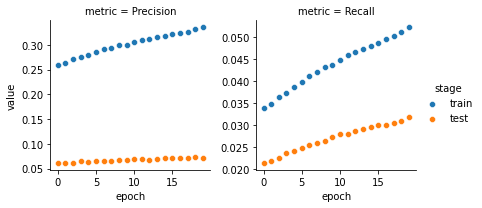

In [ ]:
output1, _ = track_model_metrics(model=model1, 
                                 train_interactions=train_interactions, 
                                 test_interactions=test_interactions, 
                                 k=K,
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS)

The second model (with both implicit and explicit data) fitting progress:

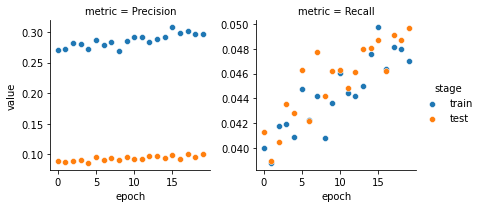

In [ ]:
output2, _ = track_model_metrics(model=model2, 
                                 train_interactions=train_interactions2, 
                                 test_interactions=test_interactions2, 
                                 k=K,                              
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS, 
                                 item_features=item_features,
                                 user_features=user_features)

These show slightly different behaviour with the two approaches, the reader can then tune the hyperparameters to improve the model fitting process.


### 4.1 Performance comparison

In addition, the model's performance metrics (based on the test dataset) can be plotted together to facilitate easier comparison as follows:

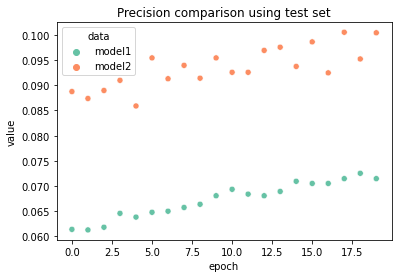

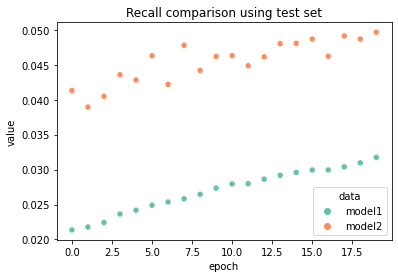

In [ ]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", 
                    y="value", 
                    hue='data',
                    data=compare_metric(df_list = [output1, output2], metric=i)
                   ).set_title(f'{i} comparison using test set');

Referring to the figures above, it is rather obvious that the number of epochs is too low as the model's performances have not stabilised. Reader can decide on the number of epochs and other hyperparameters to adjust suit the application.

As stated previously, it is interesting to see model2 (using both implicit and explicit data) performed consistently better than model1 (using only explicit ratings). 

## 5. Similar users and items

As the LightFM package operates based on latent embeddings, these can be retrieved once the model has been fitted to assess user-user and/or item-item affinity.

### 5.1 User affinity

The user-user affinity can be retrieved with the `get_user_representations` method from the fitted model as follows:

In [ ]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[ 0.17943075, -0.9845197 ,  1.724939  , ...,  3.7842598 ,
        -3.438375  ,  3.6794803 ],
       [-0.33647582,  0.7195082 ,  2.8680375 , ...,  4.22038   ,
        -4.610963  ,  4.010645  ],
       [ 0.14344296,  2.1440773 ,  1.8434161 , ...,  1.9370167 ,
        -5.640826  ,  4.653452  ],
       ...,
       [ 1.4312286 , -1.0642868 ,  2.8821077 , ...,  2.8192847 ,
        -2.7393079 ,  3.4289758 ],
       [-0.33159262,  0.7337389 ,  2.8301528 , ...,  4.112663  ,
        -4.462565  ,  3.8659678 ],
       [-0.7364118 ,  1.3901651 ,  2.1960316 , ...,  3.8899298 ,
        -4.5879855 ,  4.744391  ]], dtype=float32)

In order to retrieve the top N similar users, we can use the `similar_users` from `recommenders`. For example, if we want to choose top 10 users most similar to the user 1:

In [ ]:
similar_users(user_id=1, 
              user_features=user_features, 
              model=model2)

,userID,score
0,555,0.999998
1,54,0.999997
2,314,0.999995
3,411,0.999993
4,395,0.999992
5,465,0.999992
6,481,0.999990
7,282,0.999990
8,527,0.999990
9,57,0.999989


### 5.2 Item affinity

Similar to the user affinity, the item-item affinity can be retrieved with the `get_item_representations` method using the fitted model.

In [ ]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[-0.07855016, -0.06326439, -0.24408759, ...,  0.91503495,
        -1.1991384 ,  0.6392026 ],
       [ 0.02296161,  0.21057224,  0.52859396, ...,  0.6266738 ,
        -0.5909869 ,  0.48717606],
       [-0.05290217,  0.21497665,  0.12442638, ...,  0.64513564,
        -0.89034337,  0.47523445],
       ...,
       [ 0.37707207,  0.12548159,  0.74360174, ...,  0.19332102,
        -0.24798231, -0.3791776 ],
       [-0.27374834, -0.23832163,  0.9083196 , ...,  0.9711132 ,
        -0.36962402,  0.20986083],
       [-0.26275527, -0.3118822 ,  0.60458297, ...,  0.52483046,
        -0.46068186,  0.53892124]], dtype=float32)

The function to retrieve the top N similar items is similar to similar_users() above. For example, if we want to choose top 10 items most similar to the item 10:

In [ ]:
similar_items(item_id=10, 
              item_features=item_features, 
              model=model2)

,itemID,score
0,181,0.996882
1,14,0.996467
2,146,0.996463
3,373,0.995977
4,321,0.995873
5,114,0.995869
6,44,0.995434
7,1251,0.994995
8,352,0.994736
9,417,0.994391


In [ ]:
# Record results for tests
sb.glue('eval_precision', eval_precision)
sb.glue('eval_recall', eval_recall)
sb.glue('eval_precision2', eval_precision2)
sb.glue('eval_recall2', eval_recall2)

## 6. Conclusion

In this notebook, the background of hybrid matrix factorisation model has been explained together with a detailed example of LightFM's implementation. 

The process of incorporating additional user and item metadata has also been demonstrated with performance comparison. Furthermore, the calculation of both user and item affinity scores have also been demonstrated and extracted from the fitted model.

This notebook remains a fairly simple treatment on the subject and hopefully could serve as a good foundation for the reader.

## References

- [[1](https://arxiv.org/abs/1507.08439)]. Maciej Kula - Metadata Embeddings for User and Item Cold-start Recommendations, 2015. arXiv:1507.08439
- [[2](https://making.lyst.com/lightfm/docs/home.html)]. LightFM documentation,
- [3]. Charu C. Aggarwal - Recommender Systems: The Textbook, Springer, April 2016. ISBN 978-3-319-29659-3
- [4]. Deepak K. Agarwal, Bee-Chung Chen - Statistical Methods for Recommender Systems, 2016. ISBN: 9781107036079 
